In [ ]:
##this script is used for extracting the ms2 data from the targetd msms data and used for spectrum comparison.
##install pyopenms
# !pip install pyopenms
# !pip install numpy
# !pip install tabulate
# !pip install matchms

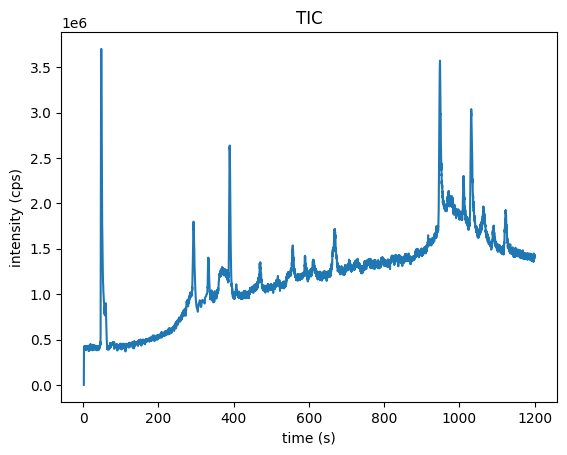

In [266]:
##check TIC 
##check extracted peak area
##
import pyopenms as oms
import numpy as np

filepath = "D:/UCSF_postdoc_topic/REVEAL_topics/R200_MSMS/B1-10pool_MSMS_12032024/B1-10_REVEAL_TarMSMS_E502a_r2.mzML"
exp = oms.MSExperiment()
oms.MzMLFile().load(filepath, exp)

import matplotlib.pyplot as plt
tic = exp.calculateTIC()
retention_times, intensities = tic.get_peaks()
# 2) get TIC data using list comprehensions
retention_times = [spec.getRT() for spec in exp]
intensities = [
    sum(spec.get_peaks()[1]) for spec in exp if spec.getMSLevel() == 1
]

# 3) get TIC data looping over spectra in MSExperiment()
retention_times = []
intensities = []
for spec in exp:
    if spec.getMSLevel() == 1:
        retention_times.append(spec.getRT())
        intensities.append(sum(spec.get_peaks()[1]))

# plot retention times and intensities and add labels
plt.plot(retention_times, intensities)
plt.title("TIC")
plt.xlabel("time (s)")
plt.ylabel("intensity (cps)")
plt.show()

In [270]:
#merge the spectrum for the precurosor at each CE level
#compare the spectrum with experimenta spectrum or CFMID spectrum
#calculate the similarity score
filepath = "D:/UCSF_postdoc_topic/REVEAL_topics/R200_MSMS/B1-10pool_MSMS_12032024/B1-10_REVEAL_TarMSMS_E502a_r2.mzML"
exp = oms.MSExperiment()
oms.MzMLFile().load(filepath, exp)
spectra = exp.getSpectra()
spectra_ms2 = [s for s in spectra if s.getMSLevel() == 2]
print(f'Number of MS2 spectra: {len(spectra_ms2)}')

#extract spectra with CE = 20
ms2_ref = oms.MSExperiment()
for s in spectra_ms2:
    precursors = s.getPrecursors()
    collision_energy = precursors[0].getMetaValue("collision energy")
    if collision_energy == 20:
        ms2_ref.addSpectrum(s)
    else :
        continue

specbeforemerge = [s for s in ms2_ref.getSpectra() if s.getMSLevel() == 2]
print(f'Number of MS2 spectra before merge: {len(specbeforemerge)}')

#merge the spectrum for the CE = 20 level
merger = oms.SpectraMerger()
param = merger.getParameters()
param.setValue("mz_tolerance", 1e-3)
param.setValue("rt_tolerance", "5.0")
merger.setParameters(param)
merger.mergeSpectraPrecursors(ms2_ref)
specmerge = [s for s in ms2_ref.getSpectra() if s.getMSLevel() == 2]
print(f'Number of MS2 spectra after merge: {len(specmerge)}')

#load experimental spectrum
querypath= "D:/UCSF_postdoc_topic/REVEAL_topics/R200_MSMS/NOV22/B1-10-MSMS-neg_I5.mzML"
querysp = oms.MSExperiment()
oms.MzMLFile().load(querypath, querysp)

expspectra = querysp.getSpectra()
targetms = 144.04558
def ppm_error(mz, target):
    return abs(mz - target) / target * 1e6

ms2_query = oms.MSExperiment()
for s in expspectra:
    if s.getMSLevel() == 1:
        continue
    precursors = s.getPrecursors()
    mslevel = s.getMSLevel()
    collision_energy = precursors[0].getMetaValue("collision energy")
    ms_error = ppm_error(precursors[0].getMZ(), targetms)
    if ms_error < 10 and mslevel == 2 and collision_energy == 20:
        ms2_query.addSpectrum(s)
    else :
        continue

expms2beforemerg = [s for s in ms2_query.getSpectra() if s.getMSLevel() == 2]
print(f'Number of MS2 spectra before merge: {len(expms2beforemerg)}')

#merget the ms spectra
merger = oms.SpectraMerger()
param = merger.getParameters()
param.setValue("mz_tolerance", 1e-3)
param.setValue("rt_tolerance", "5.0")
merger.setParameters(param)
merger.mergeSpectraPrecursors(ms2_query)
expms2aftermerg = [s for s in ms2_query.getSpectra() if s.getMSLevel() == 2]
print(f'Number of MS2 spectra after merge: {len(expms2aftermerg)}')
#spectrum alignment between sample spectrum and standard spectrum
#spectrum dot product for similarity score


Number of MS2 spectra: 72
Number of MS2 spectra before merge: 24
Number of MS2 spectra after merge: 1
Number of MS2 spectra before merge: 6
Number of MS2 spectra after merge: 1


In [277]:
def ppm_error(mz, target):
    return abs(mz - target) / target * 1e6

def preprocess_spectra(filepath, target_mz, ce_level, tolerance=10):
    # Extract spectra with specified collision energy level
    # Filter spectra based on targeted m/z value
    if target_mz is None:
        raise ValueError("Please provide a target m/z value.")
    ce_level = float(ce_level)
    tolerance = float(tolerance)
    target_mz = float(target_mz)
    spectra = oms.MSExperiment()
    oms.MzMLFile().load(filepath, spectra)
    ms2_spec = spectra.getSpectra()

    ms2_query = oms.MSExperiment()
    for s in ms2_spec:
        if s.getMSLevel() == 1:
            continue
        precursors = s.getPrecursors()
        mslevel = s.getMSLevel()
        collision_energy = precursors[0].getMetaValue("collision energy")
        ms_error = ppm_error(precursors[0].getMZ(), target_mz)
        if ms_error < tolerance and mslevel == 2 and collision_energy == ce_level:
            ms2_query.addSpectrum(s)
        else :
            continue

    ms2beforemerg = [s for s in ms2_query.getSpectra() if s.getMSLevel() == 2]
    print(f'Number of MS2 spectra before merge: {len(ms2beforemerg)}')

    #merget the ms spectra
    merger = oms.SpectraMerger()
    param = merger.getParameters()
    param.setValue("mz_tolerance", 1e-3)
    param.setValue("rt_tolerance", "5.0")
    merger.setParameters(param)
    merger.mergeSpectraPrecursors(ms2_query)
    ms2aftermerg = [s for s in ms2_query.getSpectra() if s.getMSLevel() == 2]
    print(f'Number of MS2 spectra after merge: {len(ms2aftermerg)}')
    return ms2_query

In [ ]:
# #helper function for spectrum comparison
# def normalize_and_filter(spectrum, baseline):
#     try:
#         mz, intensity = spectrum.get_peaks()
#     except AttributeError:
#         mz, intensity = zip(*spectrum)
#         mz = np.array(mz)
#         intensity = np.array(intensity)
#     intensity = np.round((intensity / max(intensity)) * 100, 1)
#     indices = np.where(intensity >= baseline)
#     return mz[indices], intensity[indices]

# def ppm_error(mz, target):
#     return abs(mz - target) / target * 1e6

# def bin_spectrum(mz, intensity, bin_size=0.0005):
#     bins = np.arange(min(mz), max(mz) + bin_size, bin_size)
#     binned_mz = np.digitize(mz, bins)
#     binned_intensity = np.zeros(len(bins) - 1)
#     for i in range(1, len(bins)):
#         indices = np.where(binned_mz == i)
#         if len(indices[0]) > 0:
#             binned_intensity[i - 1] = np.max(intensity[indices])
#     return bins[:-1], binned_intensity

# # Cosine similarity score for spectra comparison function
# #spectrum 2 as the reference spectrum
# def spectrum_similarity(spectrum1, spectrum2, tolerance=5.0, baseline=10):
#     # Format spectra and normalize the peaks
#     mz1, int1 = normalize_and_filter(spectrum1, baseline)
#     mz2, int2 = normalize_and_filter(spectrum2, baseline)

#     #reference spectrum quality check
#     if len(mz2) <= 1:
#         print("Warning: The reference spectrum is only with one fragment.")
#         return 0
    
#     #bin the spectrum
#     bin_mz1, bin_int1 = bin_spectrum(mz1, int1)
#     bin_mz2, bin_int2 = bin_spectrum(mz2, int2)

#     #bin the spectra
    

#     # Align the m/z of the spectra using spectrum 2 as the reference
#     aligned_mz = []
#     aligned_int1 = []
#     aligned_int2 = []

#     # for mz in mz2:
#     #     # Find matching m/z in spectrum 1 within the given ppm tolerance
#     #     match_indices = [i for i, mz_val in enumerate(mz1) if ppm_error(mz_val, mz) <= tolerance]
#     #     if len(match_indices) > 0:
#     #         aligned_mz.append(mz)
#     #         aligned_int1.append(int1[match_indices[0]])
#     #         aligned_int2.append(int2[np.where(mz2 == mz)[0][0]])
#     #     else:
#     #         aligned_mz.append(mz)
#     #         aligned_int1.append(0)
#     #         aligned_int2.append(int2[np.where(mz2 == mz)[0][0]])

#     # Convert aligned intensities to numpy arrays
#     aligned_int1 = np.array(aligned_int1)
#     aligned_int2 = np.array(aligned_int2)
#     aligned_mz = np.array(aligned_mz)

#     # Check for duplicated m/z values
#     if len(aligned_mz) != len(set(aligned_mz)):
#         print("Warning: The m/z tolerance is set too high, resulting in duplicate matches.")
    
#     if np.count_nonzero(aligned_int1) == 1:
#         print("Warning: only one peak matched.")
    
#         # Cosine similarity score for spectra comparison
#     # similarity_score = np.dot(aligned_int1, aligned_int2) / (np.sqrt(np.sum(np.square(aligned_int1))) * np.sqrt(np.sum(np.square(aligned_int2))))
#     #or weighted cosine similarity score
#     #given weights
#     a =0   #1.3
#     b = 1  #0.53
#     u_prime = (aligned_mz**a)*(aligned_int1**b)
#     v_prime = (aligned_mz**a)*(aligned_int2**b)
#     numerator = np.dot(u_prime, v_prime)
#     denominator = (np.sqrt(np.sum(u_prime**2)) * np.sqrt(np.sum(v_prime**2)))
#     if denominator == 0:
#         similarity_score = 0.0
#     else:
#         similarity_score = numerator / denominator

#     # Plot mirror plot for aligned spectra
#     if similarity_score > 0 & np.count_nonzero(aligned_int1)>1:
#         plt.show()
#         plt.figure(figsize=(10, 6))
#         plt.bar(aligned_mz, aligned_int1, width=0.8, color='b', alpha=0.6, label='Query Spectrum')
#         plt.bar(aligned_mz, -aligned_int2, width=0.8, color='r', alpha=0.6, label='Reference Spectrum')
#         plt.axhline(0, color='k', linewidth=0.8)  # Add a solid black line to separate Spectrum 1 and Spectrum 2
#         # plt.text(0.1, 0.8, f'Similarity Score: {similarity_score:.2f}', fontsize=12, transform=plt.gca().transAxes)
#         plt.xlabel('m/z')
#         plt.ylabel('Intensity')
#         plt.title('Mirror Plot of Aligned Spectra')
#         plt.legend()
#         plt.show()
#         print(f'aligned_mz: {aligned_mz}',
#               f'aligned_int1: {aligned_int1}',
#               f'aligned_int2: {aligned_int2}')
    
#     return similarity_score

In [596]:
# Example usage
target_mz = 144.04558
q_filepath= "D:/UCSF_postdoc_topic/REVEAL_topics/R200_MSMS/NOV22/B1-10-MSMS-neg_I5.mzML"
ref_filepath = "D:/UCSF_postdoc_topic/REVEAL_topics/R200_MSMS/B1-10pool_MSMS_12032024/B1-10_REVEAL_TarMSMS_E502a_r2.mzML"
ms2_query = preprocess_spectra(q_filepath, target_mz, 20, tolerance=10)
ms2_ref = preprocess_spectra(ref_filepath, target_mz, 20, tolerance=10)

spectrum_similarity(ms2_query[0], ms2_ref[0], tolerance = 5.0, baseline = 10)

Number of MS2 spectra before merge: 6
Number of MS2 spectra after merge: 1
Number of MS2 spectra before merge: 24
Number of MS2 spectra after merge: 1


0.3911381206420773

In [ ]:
import re
import numpy as np

def parse_msp_file(msp_file_path, polarity):
    """
    Parses the .msp file to extract all spectrum information.
    
    Args:
        msp_file_path (str): Path to the .msp file.

    Returns:
        dict: A dictionary where keys are InChIKey or SMILES and values are lists of spectra data.
    """
    spectra = {}
    if polarity == "positive":
        p_type = "[M+H]+"
    elif polarity == "negative":
        p_type = "[M-H]-"
    else:
        raise ValueError("Invalid polarity. Please specify 'positive' or 'negative'.")
    
    with open(msp_file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        entries = content.split('Name: ')
        for entry in entries[1:]:
            lines = entry.strip().split('\n')
            metadata = {}
            spectrum_data = []
            key = None

            for line in lines:
                if line.startswith("InChIKey:"):
                    key = line.split(": ")[1].strip()
                elif line.startswith("SMILES:") and key is None:
                    key = line.split(": ")[1].strip()
                elif line.startswith("Spectrum_type:"):
                    spectrum_type = line.split(": ")[1].strip()
                elif line.startswith("Precursor_type:"):
                    precursor_type = line.split(": ")[1].strip()
                elif line.startswith("Num Peaks:"):
                    num_peaks = int(line.split(": ")[1].strip())
                    spectrum_data = lines[lines.index(line)+1:lines.index(line)+1+num_peaks]
                elif ": " in line:
                    k, v = line.split(": ", 1)
                    metadata[k.strip()] = v.strip()

            # Retain only spectra with "Spectrum_type: MS2"
            if spectrum_type == "MS2" and precursor_type == p_type  and key and spectrum_data:
                if key not in spectra:
                    spectra[key] = []
                spectra[key].append({
                    "metadata": metadata,
                    "spectrum": [(float(mz), float(intensity)) for mz, intensity in (line.split() for line in spectrum_data)]
                })

    return spectra


def parse_mona_database(db_file_path, polarity):
    """
    Parses an alternate database format to extract all spectrum information based on polarity.

    Args:
        db_file_path (str): Path to the database file.
        polarity (str): The ion polarity to filter ("positive" or "negative").

    Returns:
        dict: A dictionary where keys are InChIKey or SMILES and values are lists of spectra data.
    """
    spectra = {}

    if polarity == "positive":
        p_type = "[M+H]+"
    elif polarity == "negative":
        p_type = "[M-H]-"
    else:
        raise ValueError("Invalid polarity. Please specify 'positive' or 'negative'.")

    with open(db_file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        entries = content.split('NAME: ')  # "NAME:" marks the beginning of each spectrum.
        for entry in entries[1:]:
            lines = entry.strip().split('\n')
            metadata = {}
            spectrum_data = []
            key = None

            for line in lines:
                if line.startswith("INCHIKEY:"):
                    key = line.split(": ")[1].strip()
                elif line.startswith("SMILES:") and key is None:
                    key = line.split(": ")[1].strip()
                elif line.startswith("PRECURSORTYPE:"):
                    ionization = line.split(": ")[1].strip()
                elif line.startswith("Num Peaks:"):
                    num_peaks = int(line.split(": ")[1].strip())
                    spectrum_data = [tuple(map(float, peak.split())) for peak in lines[lines.index(line)+1:] if peak.strip()]
                elif ": " in line:
                    k, v = line.split(": ", 1)
                    metadata[k.strip()] = v.strip()

            # Retain only spectra matching the desired polarity
            if ionization == p_type and key and spectrum_data:
                if key not in spectra:
                    spectra[key] = []
                spectra[key].append({
                    "metadata": metadata,
                    "spectrum": spectrum_data
                })

    return spectra


def get_spectrum_by_key(spectra, key):
    """
    Retrieves all spectrum information by InChIKey or SMILES.

    Args:
        spectra (dict): Parsed spectra data.
        key (str): The InChIKey or SMILES to search for.

    Returns:
        dict: A dictionary where keys are collision energies and values are spectra.
    """
    if key not in spectra:
        return {}

    grouped_spectra = {}
    for spec in spectra[key]:
        collision_energy = spec["metadata"].get("Collision_energy", spec["metadata"].get("COLLISIONENERGY", "Unknown"))
        if collision_energy not in grouped_spectra:
            grouped_spectra[collision_energy] = []
        grouped_spectra[collision_energy].append(spec["spectrum"])

    return grouped_spectra

In [ ]:
# Example Usage:
database1 = "D:/UCSF_postdoc_topic/REVEAL_topics/Spectrum_database/MassBank_NIST.msp"
database2 = "D:/UCSF_postdoc_topic/REVEAL_topics/Spectrum_database/MSMS_Public_EXP_NEG_VS17.msp"
database3 = "D:/UCSF_postdoc_topic/REVEAL_topics/Spectrum_database/MoNA-export-All_LC-MS-MS_Orbitrap.msp"

#CFMID database
database4 = "D:/UCSF_postdoc_topic/REVEAL_topics/Spectrum_database/CFMID-plastic/compiled_spectrum_library_neg_energy0.msp"
database5 = "D:/UCSF_postdoc_topic/REVEAL_topics/Spectrum_database/CFMID-plastic/compiled_spectrum_library_neg_energy1.msp"
database6 = "D:/UCSF_postdoc_topic/REVEAL_topics/Spectrum_database/CFMID-plastic/compiled_spectrum_library_neg_energy2.msp"

spectra_data = parse_msp_file(database1, polarity="negative")
mona_data = parse_mona_database(database2, polarity="negative")
mona_obtrap_data = parse_msp_file(database3, polarity="negative")
cfmid_e0_data = parse_msp_file(database4, polarity="negative")
cfmid_e1_data = parse_msp_file(database5, polarity="negative")
cfmid_e2_data = parse_msp_file(database6, polarity="negative")

In [585]:
key_to_search = "MCJGNVYPOGVAJF-UHFFFAOYSA-N"  # DTXSI5020730
# key_to_search = "OC1=CC=CC2=CC=CN=C12"  # DTXSI5020730
# key_to_search = "WOZVHXUHUFLZGK-UHFFFAOYSA-N"  # DTXSID0020498
# key_to_search = "COC(=O)c1ccc(C(=O)OC)cc1" # DTXSID0020498
# key_to_search = 'WSGFXVFLWVXTCJ-UHFFFAOYSA-N' #DTXSID8041373
# key_to_search = "CCCCCC=CCC1CC(=O)OC1=O" #DTXSID8041373
# key_to_search = 'ZXVONLUNISGICL-UHFFFAOYSA-N'
# Retrieve spectra by key
mbank_spectra = get_spectrum_by_key(spectra_data, key_to_search)
mona_spectra = get_spectrum_by_key(mona_data, key_to_search)
mona_obtrap_spectra = get_spectrum_by_key(mona_obtrap_data, key_to_search)
cfmid_e0_spectra = get_spectrum_by_key(cfmid_e0_data, key_to_search)
cfmid_e1_spectra = get_spectrum_by_key(cfmid_e1_data, key_to_search)   
cfmid_e2_spectra = get_spectrum_by_key(cfmid_e2_data, key_to_search)

print(len(mbank_spectra.keys()))
print(len(mona_spectra.keys()))
print(len(mona_obtrap_spectra.keys()))
print(len(cfmid_e0_spectra.keys()))
print(len(cfmid_e1_spectra.keys()))
print(len(cfmid_e2_spectra.keys()))

0
0
1
0
0
0


In [586]:
import copy

query_spectrum = copy.deepcopy(ms2_ref[0])

#Calculate similarity for each collision energy
for collision_energy, spectra in mona_obtrap_spectra.items():
    for spectrum in spectra:
        similarity = spectrum_similarity(spectrum, query_spectrum, tolerance = 5.0, baseline = 10)
        print(f"Collision Energy: {collision_energy}, Similarity: {similarity}")

Collision Energy: HCD (NCE 20-30-40%), Similarity: 0.3700961547299127


In [360]:
##import library for spectrum comparison
import pandas as pd
negfilepath = "D:/UCSF_postdoc_topic/REVEAL_topics/REVEAL_200samples_analysis/Neg_AlignmentResults/Matched_peak_neg_spectrum_search.csv"
negtarget = pd.read_csv(negfilepath)
negtarget.head()

#perform spectrum search for each row by InChiKey_origin column, and add number of found spectra to the dataframe from each database.

for iter, row in negtarget.iterrows():
    key = row['InChiKey_origin']
    mbank_spectra = get_spectrum_by_key(spectra_data, key)
    mona_spectra = get_spectrum_by_key(mona_data, key)
    mona_obtrap_spectra = get_spectrum_by_key(mona_obtrap_data, key)
    cfmid_e0_spectra = get_spectrum_by_key(cfmid_e0_data, key)
    cfmid_e1_spectra = get_spectrum_by_key(cfmid_e1_data, key)   
    cfmid_e2_spectra = get_spectrum_by_key(cfmid_e2_data, key)
    negtarget.loc[iter, 'mbank_spectra'] = len(mbank_spectra.keys())
    negtarget.loc[iter, 'mona_spectra'] = len(mona_spectra.keys())
    negtarget.loc[iter, 'mona_obtrap_spectra'] = len(mona_obtrap_spectra.keys())
    negtarget.loc[iter, 'cfmid_e0_spectra'] = len(cfmid_e0_spectra.keys())
    negtarget.loc[iter, 'cfmid_e1_spectra'] = len(cfmid_e1_spectra.keys())
    negtarget.loc[iter, 'cfmid_e2_spectra'] = len(cfmid_e2_spectra.keys())
    negtarget.loc[iter, 'total_spectra'] = len(mbank_spectra.keys()) + len(mona_spectra.keys()) + len(mona_obtrap_spectra.keys()) + len(cfmid_e0_spectra.keys()) + len(cfmid_e1_spectra.keys()) + len(cfmid_e2_spectra.keys())

filteredtargetsp = negtarget[negtarget['total_spectra'] > 0].copy()

In [362]:
filteredtargetsp

,AlignmentID,Average Rt(min),Average Mz,MSMS_injection,targetedMS2_pass,Matched Compound,DTXSID_Hits,SMILES_STD,InChiKey_origin,mbank_spectra,mona_spectra,mona_obtrap_spectra,cfmid_e0_spectra,cfmid_e1_spectra,cfmid_e2_spectra,total_spectra
2,273,4.694,197.02040,4,y,CC1=C(O)C(=CC(=C1)[N+]([O-])=O)[N+]([O-])=O,DTXSID1022053,Cc1cc([N+](=O)[O-])cc([N+](=O)[O-])c1O,ZXVONLUNISGICL-UHFFFAOYSA-N,24.0,12.0,12.0,0.0,0.0,0.0,48.0
8,1478,5.224,144.04558,5,y,OC1=CC=CC2=CC=CN=C12,DTXSID5020730,Oc1cccc2cccnc12,MCJGNVYPOGVAJF-UHFFFAOYSA-N,0.0,0.0,1.0,0.0,0.0,0.0,1.0
16,1045,6.839,313.11957,3,y,NC1=CC=C(C=C1)C(=O)OCCCOC(=O)C1=CC=C(N)C=C1,DTXSID3044960,Nc1ccc(C(=O)OCCCOC(=O)c2ccc(N)cc2)cc1,YPACMOORZSDQDQ-UHFFFAOYSA-N,3.0,0.0,0.0,0.0,0.0,0.0,3.0
20,1042,7.640,313.11932,7,y,NC1=CC=C(C=C1)C(=O)OCCCOC(=O)C1=CC=C(N)C=C1,DTXSID3044960,Nc1ccc(C(=O)OCCCOC(=O)c2ccc(N)cc2)cc1,YPACMOORZSDQDQ-UHFFFAOYSA-N,3.0,0.0,0.0,0.0,0.0,0.0,3.0
24,1048,8.087,313.11972,6,y,NC1=CC=C(C=C1)C(=O)OCCCOC(=O)C1=CC=C(N)C=C1,DTXSID3044960,Nc1ccc(C(=O)OCCCOC(=O)c2ccc(N)cc2)cc1,YPACMOORZSDQDQ-UHFFFAOYSA-N,3.0,0.0,0.0,0.0,0.0,0.0,3.0
27,2259,8.388,398.93625,3,y,OS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,DTXSID7040150,O=S(=O)(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,QZHDEAJFRJCDMF-UHFFFAOYSA-N,4.0,4.0,0.0,0.0,0.0,0.0,8.0
39,986,10.526,498.93045,2,y,OS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,DTXSID3031864,O=S(=O)(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,YFSUTJLHUFNCNZ-UHFFFAOYSA-N,13.0,14.0,1.0,0.0,0.0,0.0,28.0
40,984,10.638,498.93015,4,y,OS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,DTXSID3031864,O=S(=O)(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,YFSUTJLHUFNCNZ-UHFFFAOYSA-N,13.0,14.0,1.0,0.0,0.0,0.0,28.0
51,119,12.982,297.24307,3,y,CCCCCC[C@@H](O)C\C=C/CCCCCCCC(O)=O,DTXSID0041567,CCCCCC[C@@H](O)C/C=C\CCCCCCCC(=O)O,WBHHMMIMDMUBKC-QJWNTBNXSA-N,6.0,6.0,6.0,0.0,0.0,0.0,18.0
59,2483,13.974,299.25974,2,y,CCCCCCC(O)CCCCCCCCCCC(O)=O,DTXSID8026725,CCCCCCC(O)CCCCCCCCCCC(=O)O,ULQISTXYYBZJSJ-UHFFFAOYSA-N,6.0,6.0,6.0,0.0,0.0,0.0,18.0


In [587]:
key_to_search = 'YFSUTJLHUFNCNZ-UHFFFAOYSA-N'
# Retrieve spectra by key
mbank_spectra = get_spectrum_by_key(spectra_data, key_to_search)
mona_spectra = get_spectrum_by_key(mona_data, key_to_search)
mona_obtrap_spectra = get_spectrum_by_key(mona_obtrap_data, key_to_search)
cfmid_e0_spectra = get_spectrum_by_key(cfmid_e0_data, key_to_search)
cfmid_e1_spectra = get_spectrum_by_key(cfmid_e1_data, key_to_search)   
cfmid_e2_spectra = get_spectrum_by_key(cfmid_e2_data, key_to_search)

print(len(mbank_spectra.keys()))
print(len(mona_spectra.keys()))
print(len(mona_obtrap_spectra.keys()))
print(len(cfmid_e0_spectra.keys()))
print(len(cfmid_e1_spectra.keys()))
print(len(cfmid_e2_spectra.keys()))

13
14
1
0
0
0


Number of MS2 spectra before merge: 7
Number of MS2 spectra after merge: 1


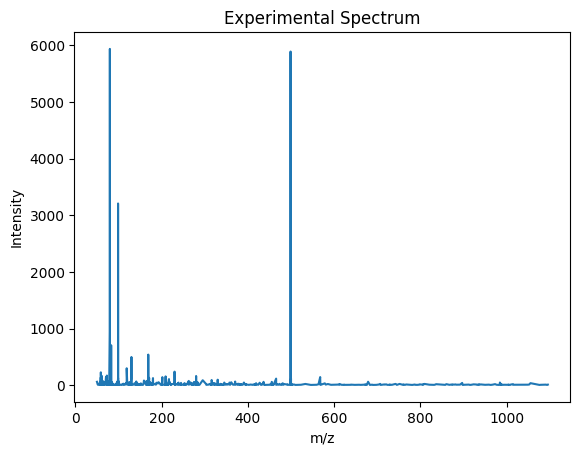

Collision Energy: 40 eV, Similarity: 0
Collision Energy: 40 eV, Similarity: 0
Collision Energy: 20 eV, Similarity: 0
Collision Energy: 20 eV, Similarity: 0
Collision Energy: 50 eV, Similarity: 0
Collision Energy: 10 eV, Similarity: 0
Collision Energy: 10 eV, Similarity: 0
Collision Energy: 30 eV, Similarity: 0
Collision Energy: 30 eV, Similarity: 0
Collision Energy: Ramp 32.0-47.9 eV, Similarity: 0.9280663062062157
Collision Energy: 35  (nominal), Similarity: 0
Collision Energy: 30eV, Similarity: 0.0
Collision Energy: 60eV, Similarity: 0.0
Collision Energy: 40eV, Similarity: 0.0
Collision Energy: 10eV, Similarity: 0
Collision Energy: 50eV, Similarity: 0.0
Collision Energy: 20eV, Similarity: 0


In [602]:
#import spectrum from serum
target_mz = 498.93045	
#q_filepath= "D:/UCSF_postdoc_topic/REVEAL_topics/R200_MSMS/NOV22/B1-10-MSMS-neg_I4.mzML"
# q_filepath= "D:/UCSF_postdoc_topic/REVEAL_topics/R200_MSMS/NOV22/B1-10-MSMS-neg_I5.mzML"
# q_filepath= "D:/UCSF_postdoc_topic/REVEAL_topics/R200_MSMS/NOV22/B1-10-MSMS-neg_I3.mzML"
# q_filepath= "D:/UCSF_postdoc_topic/REVEAL_topics/R200_MSMS/NOV22/B1-10-MSMS-neg_I7.mzML"
# q_filepath= "D:/UCSF_postdoc_topic/REVEAL_topics/R200_MSMS/NOV22/B1-10-MSMS-neg_I6.mzML"
q_filepath= "D:/UCSF_postdoc_topic/REVEAL_topics/R200_MSMS/NOV22/B1-10-MSMS-neg_I2.mzML"
ms2_query = preprocess_spectra(q_filepath, target_mz, 40, tolerance=10)
query_spectrum = copy.deepcopy(ms2_query[0])

#plot the spectrum
mz, intensity = query_spectrum.get_peaks()
plt.plot(mz, intensity)
plt.title("Experimental Spectrum")
plt.xlabel("m/z")
plt.ylabel("Intensity")
plt.show()

# #Calculate similarity for each collision energy
for collision_energy, spectra in mbank_spectra.items():
    for spectrum in spectra:
        similarity = spectrum_similarity(query_spectrum, spectrum, tolerance = 5.0, baseline = 10)
        print(f"Collision Energy: {collision_energy}, Similarity: {similarity}")

In [10]:
import matchms 
from matchms import calculate_scores
from matchms import Spectrum
from matchms.similarity import CosineGreedy
import numpy as np
import pandas as pd

reference = Spectrum(mz=np.array([100, 150, 200.]),
                     intensities=np.array([0.7, 0.2, 0.1]))
query = Spectrum(mz=np.array([100, 140, 190.]),
                 intensities=np.array([0.4, 0.2, 0.1]))

# Use factory to construct a similarity function
cosine_greedy = CosineGreedy(tolerance=0.001, mz_power=1.3, intensity_power=0.53)

score = cosine_greedy.pair(reference, query)

print(f"Cosine score is {score['score']:.2f} with {score['matches']} matched peaks")

2024-12-08 22:42:22,512:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2024-12-08 22:42:22,515:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
Cosine score is 0.34 with 1 matched peaks
